In [21]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from plotnine import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse
warnings.filterwarnings("ignore")

In [22]:
# Import data
data = pd.read_csv("/Users/jacopobinati/Desktop/Prediction ML/assignment 3/datafinal2.csv")

## Define helper functions

In [23]:
color=['#406390', 'green']
def regression_results(y_true, y_pred):
    
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def coef_matrix(X, model):

    coef_matrix = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix = coef_matrix.append({'variable': 'Intercept', 'coefficient': np.asscalar(model.intercept_)}, ignore_index=True)
    return(coef_matrix)

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = (0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = (0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks=np.arange(0, 1.1, 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks=np.arange(0, 1.1, 0.1)) +\
        scale_x_reverse(breaks=np.arange(0, 1.1, 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

## Define variable sets 

In [24]:
rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap"]
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "personnel_exp_pl"]
engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]
engvar3=[]
for col in data.columns:
    if col.endswith('flag_low') or col.endswith('flag_high') or col.endswith('flag_error') or col.endswith('flag_zero'):
        engvar3.append(col)


hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management"]

In [25]:
#Creat dummy columns from category variables and drop first level
ind2_catmat = patsy.dmatrix("0 + C(ind2_cat)",data, return_type="dataframe")
ind2_catmat = ind2_catmat.drop(['C(ind2_cat)[26.0]'], axis=1)

m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)",data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(m_region_loc)[Central]'], axis=1)

urban_mmat = patsy.dmatrix("0 + C(urban_m)",data, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1.0]'], axis=1)

In [26]:
# Define X1
basevars = data[["profit_loss_year_pl", "profit_loss_year2_pl"]]
X1 = pd.concat([basevars, ind2_catmat], axis=1)
# Define X2
X2additional_vars = data[["fixed_assets_bs", "share_eq_bs","curr_liab_bs", "curr_liab_bs_flag_high", \
                          "curr_liab_bs_flag_error",  "age", "foreign_management", "ebtda", 'ebtda_to_assets']]
X2 = pd.concat([X1, X2additional_vars], axis=1)
# Define X3
firm = pd.concat([data[["age", "age2", "new"]], ind2_catmat, m_region_locmat, urban_mmat], axis=1)
X3 = pd.concat([data[["profit_loss_year_pl", "profit_loss_year2_pl"] + engvar], firm], axis=1)
# Define X4
X4 = pd.concat([data[["profit_loss_year_pl", "profit_loss_year2_pl"] + engvar \
                                 + engvar2 + engvar3 + hr + qualityvars], firm], axis=1)

In [27]:
# Define X5
#Creat matrix for interactions1 variables
int1mat = patsy.dmatrix("0 + C(ind2_cat):age + C(ind2_cat):age2 + C(ind2_cat):total_assets_bs \
                + C(ind2_cat):sales_mil_log + C(ind2_cat):ceo_age + C(ind2_cat):foreign_management \
                + C(ind2_cat):female + C(ind2_cat):C(urban_m) + C(ind2_cat):labor_avg_mod", data, return_type="dataframe")
#Drop first level to get k-1 dummies out of k categorical levels 
for col in int1mat.columns:
    if col.startswith('C(ind2_cat)[26.0]') or col.endswith('C(urban_m)[1.0]'):
        int1mat = int1mat.drop([col], axis=1)
        
#Creat matrix for interactions2 variables        
int2mat = patsy.dmatrix("0 + profit_loss_year_pl:age + profit_loss_year_pl:female + C(urban_m):foreign_management", data, return_type="dataframe")
X5 = pd.concat([X4, int1mat, int2mat], axis=1)

In [28]:
# Define logitvars for LASSO
logitvars = pd.concat([X4, int1mat, int2mat], axis=1)

In [29]:
# Define rfvars for RF (no interactions, no modified features)
rfvars  = pd.concat([data[["profit_loss_year_pl", "profit_loss_year2_pl"] + rawvars + hr + qualityvars], firm], axis=1)

In [30]:
y = data['fast_growth']

In [31]:
index_train, index_holdout= train_test_split(
    data.index.values, train_size=round(0.8*len(data.index)), random_state=42)

y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]

In [32]:
data = data.query("year==2013 & status_alive == 1")

In [33]:
data.head()

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,default_f,sales_mil_log_sq,ebtda,t2_ebtda,ebtda_to_assets,f_d1_sales_mil_log_low,f_d1_sales_mil_log_high,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq,fast_growth
42538,2013,1001541.0,2013-01-01,2013-12-31,2292.592529,4811.111328,925.925903,0.0,74.074074,74.074074,...,no_default,26.966801,3092.592552,2525.925858,-0.002935,0,1,1.500000,2.250000,False
42539,2013,1002029.0,2013-01-01,2013-12-31,14255.555664,217103.703125,161174.078125,0.0,0.000000,0.000000,...,no_default,1.054824,30844.444336,15359.259033,-0.054857,0,0,-1.155013,1.334055,False
42540,2013,1011889.0,2013-01-01,2013-12-31,66125.929688,235114.812500,16555.554688,0.0,0.000000,0.000000,...,no_default,0.666460,131470.375000,160170.372253,0.024464,0,0,0.019109,0.000365,False
42541,2013,1014183.0,2013-01-01,2013-12-31,6970.370605,209562.968750,5703.703613,0.0,0.000000,0.000000,...,no_default,4.632597,14492.592773,7888.888977,-0.020476,0,0,-0.110044,0.012110,False
42542,2013,1018301.0,2013-01-01,2013-12-31,0.000000,1488.888916,1170.370361,0.0,0.000000,0.000000,...,no_default,22.789243,-666.666687,262.962952,0.017291,0,0,0.228529,0.052225,False


# TASK 1

# 1. Probability Prediction

In [34]:
#specify cross-validation method
k = KFold(n_splits=5, shuffle=True, random_state=42)

## Logit

In [35]:
# no regularisation needed so setting the paremeter to very high value
C_value_logit=[1e20]

In [36]:
# Train Logit Models ----------------------------------------------
logit_model_vars = [X1.iloc[index_train], X2.iloc[index_train], X3.iloc[index_train], X4.iloc[index_train], X5.iloc[index_train]]

logit_models = dict()
CV_RMSE_folds = dict()

for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(Cs=C_value_logit, cv=k, refit=True, scoring='neg_brier_score', 
                            solver="newton-cg", tol=1e-7, random_state=42)
    logit_models['M'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    # Calculate RMSE on test for each fold
    CV_RMSE_folds['M'+str(i+1)] = np.sqrt(-1*(logit_models['M'+str(i+1)].scores_[1])).tolist()

## LASSO

In [37]:
normalized_logitvars=pd.DataFrame(StandardScaler().fit_transform(logitvars.iloc[index_train]))
normalized_logitvars.columns=logitvars.columns

In [38]:
lambdas=list(10**np.arange(-1,-4.01, -1/3))
n_obs = normalized_logitvars.shape[0]*4/5
C_values = [1/(l*n_obs) for l in lambdas]

logLasso = LogisticRegressionCV(Cs=C_values, penalty='l1', cv=k, refit=True, scoring='accuracy', solver='liblinear', 
                                n_jobs=-1, random_state=42)

In [39]:
logit_models["LASSO"] = logLasso.fit(normalized_logitvars, y_train)

In [40]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000274,0.699549
1,0.046416,0.000590,0.727227
2,0.021544,0.001270,0.732986
3,0.010000,0.002737,0.741132
4,0.004642,0.005897,0.745861
5,0.002154,0.012705,0.747526
6,0.001000,0.027371,0.748555
7,0.000464,0.058970,0.749869
8,0.000215,0.127047,0.749869
9,0.000100,0.273715,0.749825


In [41]:
best_lambda = cv_summary_lasso.sort_values('mean_cv_score', ascending = False).iloc[0,0]

In [42]:
#refit with negative brier score so we have RMSE values for the same cv split
logLasso_brier = LogisticRegressionCV(Cs=C_values, penalty='l1', cv=k, refit=True, scoring='neg_brier_score', 
                            solver="liblinear", random_state=42)
logLasso_brier_fitted = logLasso_brier.fit(normalized_logitvars, y_train)

In [43]:
for i, l in enumerate(lambdas):
    if l == best_lambda:
        best_lambda_i = i
        CV_RMSE_folds['LASSO'] = np.sqrt(-1*(logLasso_brier_fitted.scores_[1][:,i])).tolist()

In [44]:
CV_AUC_folds = dict()
for i in range(len(logit_model_vars)):
    LRCV_auc = LogisticRegressionCV(Cs=C_value_logit, cv=k, refit=True, scoring='roc_auc', 
                            solver="newton-cg", tol=1e-7, random_state=42)
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)
    #AUC on test 4 each fold
    CV_AUC_folds['M'+str(i+1)] = LRCV_auc_fit.scores_[1][:,0].tolist()

In [45]:
#refit with AUC so we have AUC values for the same cv split
logLasso_auc = LogisticRegressionCV(Cs=C_values, penalty='l1', cv=k, refit=True, scoring='roc_auc', 
                            solver="liblinear", random_state=42)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)
CV_AUC_folds['LASSO'] = logLasso_auc_fitted.scores_[1][:,best_lambda_i].tolist()

In [46]:
# For each model: average RMSE and average AUC for models ----------------------------------
CV_RMSE = dict()
CV_AUC = dict()
nvars = dict()

for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
    CV_AUC[key] = np.mean(CV_AUC_folds[key])
    
for key in logit_models:
    if key != 'LASSO':
        nvars[key] = logit_models[key].n_features_in_
    else:
        nvars[key] = sum(x != 0 for x in logit_models[key].coef_[0].tolist())

## Random Forest

In [47]:
rfvars_train = rfvars.iloc[index_train]
rfvars_holdout = rfvars.iloc[index_holdout]

The grid is chosen as below. The best performing parameters are used for later

In [48]:
grid = {'max_features': [5, 6, 7],
        'criterion':['gini'],
        'min_samples_split': [11, 16]}

In [49]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(prob_forest, grid, cv=k, refit='accuracy',
                                scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], n_jobs=-1)

In [50]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

In [51]:
#create CV summary table
cv_accuracy = np.zeros([6])
for i in range(5):
    cv_accuracy = cv_accuracy + prob_forest_fit.cv_results_['split' + str(i) + '_test_accuracy']
cv_accuracy = cv_accuracy/5

cv_auc = np.zeros([6])
for i in range(5):
    cv_auc = cv_auc + prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc = cv_auc/5

cv_rmse = np.zeros([6])
for i in range(5):
    cv_rmse = cv_rmse +np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse = cv_rmse/5

prob_forest_cv_results = pd.DataFrame({
    'max_features': prob_forest_fit.cv_results_['param_max_features'],
    'min_samples_split': prob_forest_fit.cv_results_['param_min_samples_split'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})

In [52]:
prob_forest_cv_results.round(3)

,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
0,5,11,0.769,0.793,0.401
1,5,16,0.770,0.793,0.401
2,6,11,0.771,0.794,0.401
3,6,16,0.771,0.793,0.401
4,7,11,0.770,0.794,0.401
5,7,16,0.770,0.794,0.401


In [53]:
#obtain optimal parameter values
best_mtry = prob_forest_fit.best_params_['max_features']
best_min_node_size = prob_forest_fit.best_params_['min_samples_split']
prob_forest_fit.best_params_

{'criterion': 'gini', 'max_features': 6, 'min_samples_split': 11}

In [54]:
prob_forest_best_results = prob_forest_cv_results[(prob_forest_cv_results.max_features == best_mtry) & 
                      (prob_forest_cv_results.min_samples_split == best_min_node_size)]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

CV_RMSE['randomforestprob'] = prob_forest_best_results.cv_rmse.values[0]
CV_AUC['randomforestprob'] = prob_forest_best_results.cv_auc.values[0]

In [55]:
CV_RMSE_folds_rf_p = list()
for i in range(5):
    rmse = np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()[prob_forest_best_results_index]
    CV_RMSE_folds_rf_p.append(rmse)
CV_RMSE_folds['rf_p'] = CV_RMSE_folds_rf_p

CV_AUC_folds_rf_p = list()
for i in range(5):
    rmse = prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc'][prob_forest_best_results_index]
    CV_AUC_folds_rf_p.append(rmse)
CV_AUC_folds['randomforestprob'] = CV_AUC_folds_rf_p

## Results

In [56]:
nvars['randomforestprob'] = len(rfvars.columns)

In [57]:
summary_results1 = pd.DataFrame({"Model": list(nvars.keys()),
                              "Number of predictors": list(nvars.values()),
                              "CV RMSE": list(CV_RMSE.values()),
                              "CV AUC": list(CV_AUC.values())
                               })

In [58]:
summary_results1.round(3)

,Model,Number of predictors,CV RMSE,CV AUC
0,M1,9,0.456,0.624
1,M2,16,0.443,0.652
2,M3,30,0.424,0.733
3,M4,74,0.420,0.744
4,M5,149,0.424,0.735
5,LASSO,127,0.415,0.757
6,randomforestprob,44,0.401,0.794


# Classification
## Start with a Loss Function where for a false positive prediction we assume we lose 100 and for a False Negative 10.

In [59]:
# Loss function
# relative cost of a false negative classification (as compared with a false positive classification)
FP = 100
FN = 10
cost = FN/FP
prevalence = y_train.sum()/len(y_train)

In [60]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

models = logit_models.copy()
models['randomforestprob'] = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True,
                                                criterion='gini', max_features=best_mtry,
                                                min_samples_split=best_min_node_size)

for i, model_name in enumerate(models):
    best_thresholds = []
    expected_loss = []
    if model_name == 'LASSO':
        X = normalized_logitvars
    elif model_name != 'randomforestprob':
        X = logit_model_vars[i]
    else:
        X = rfvars_train
    c_index = best_lambda_i if model_name == 'LASSO' else 0
    fold = 0
    for train_index, test_index in k.split(X):
        y_fold = y_train.iloc[test_index]
        if model_name != 'randomforestprob':
            X_fold = X.iloc[test_index, :]
            pred_fold = generate_fold_prediction(models[model_name], X_fold, fold, c_index)
        else:
            X_fold = rfvars_train.iloc[test_index,:]
            X_fold_train = rfvars_train.iloc[train_index,:]
            y_fold_train = y_train.iloc[train_index]

            prob_forest_best = models['randomforestprob']
            prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
            pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:,1]


        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(list(zip(
            np.abs(true_pos_rate + (1 - prevalence) / (cost * prevalence) * (1 - false_pos_rate)),
            thresholds)), key=lambda i: i[0], reverse=True)[0][1]
        if optimal_threshold > 1:
            optimal_threshold = 1
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0, 1]).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold += 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # For fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame({
        'false_pos': false_pos_rate * sum(y_fold == 0),
        'true_pos': true_pos_rate * sum(y_fold == 1),
        'false_neg': sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        'true_neg': sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        'pos': sum(y_fold == 1),
        'neg': sum(y_fold == 0),
        'n': len(y_fold),
        'thresholds': thresholds
    })

    fold5_all_coords[model_name] = all_coords


In [61]:
logit_summary2 = pd.DataFrame(best_thresholds_cv.items(),columns=['Model', 'Avg of optimal thresholds'])
logit_summary2['Threshold for Fold5'] = fold5_threshold.values()
logit_summary2['Avg expected loss'] = expected_loss_cv.values()
logit_summary2['Expected loss for Fold5'] = fold5_expected_loss.values()

In [62]:
logit_summary2_rounded = logit_summary2.round(3)
logit_summary2_rounded

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.770,0.710,3.002,2.981
1,M2,0.817,0.864,2.998,2.971
2,M3,0.942,0.893,3.002,2.978
3,M4,0.930,0.931,3.000,2.980
4,M5,0.907,0.885,3.002,2.984
5,LASSO,0.927,0.928,2.995,2.973
6,randomforestprob,0.872,0.842,2.987,2.942


# 3. Confusion Table and Discussion

In [63]:
# Take the best model - RF - and predict on holdout data

best_model = models['randomforestprob']
best_model_X_holdout = rfvars_holdout


logit_fit_probabilities = best_model.fit(rfvars_train, y_train)
logit_predicted_probabilities_holdout = logit_fit_probabilities.predict_proba(best_model_X_holdout)[:,1]


In [64]:
# Pick best model based on average expected loss ----------------------------------
#RF
best_logit_optimal_treshold = best_thresholds_cv["randomforestprob"]

# Confusion table on holdout
holdout_treshold = np.where(logit_predicted_probabilities_holdout < best_logit_optimal_treshold, 0, 1)

cm_object1 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cm1 = pd.DataFrame(cm_object1, 
    index=['Actual slow growth', 'Actual fast growth'], 
    columns=['Predicted slow growth', 'Predicted fast growth'])
cm1

cm1_percentage = cm1 / cm1.values.sum() * 100
cm1_percentage_rounded = cm1_percentage.round(1)

In [65]:
cm1_percentage_rounded.T

,Actual slow growth,Actual fast growth
Predicted slow growth,70.1,29.8
Predicted fast growth,0.0,0.1


Loss plot with the optimal threshold for the RF model in fold 5

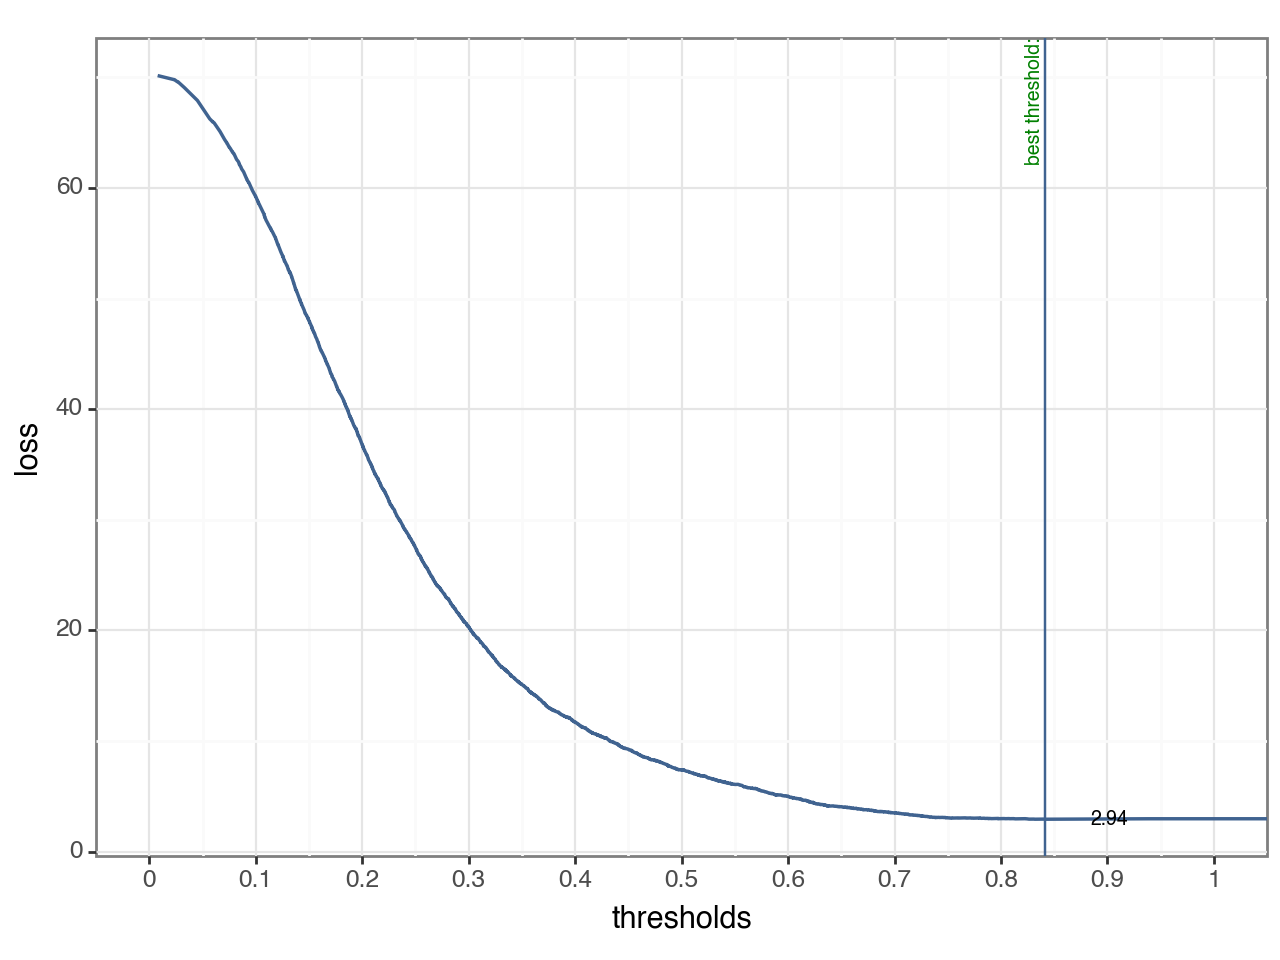

<Figure Size: (640 x 480)>

In [68]:
fig = create_loss_plot(fold5_all_coords['randomforestprob'], fold5_threshold['randomforestprob'], fold5_expected_loss['randomforestprob'])
fig.save('/Users/jacopobinati/Desktop/Prediction ML/assignment 3/visualisations/TASK1/loss_plot.png')
fig

ROC plot with the optimal threshold for the RF model in fold 5

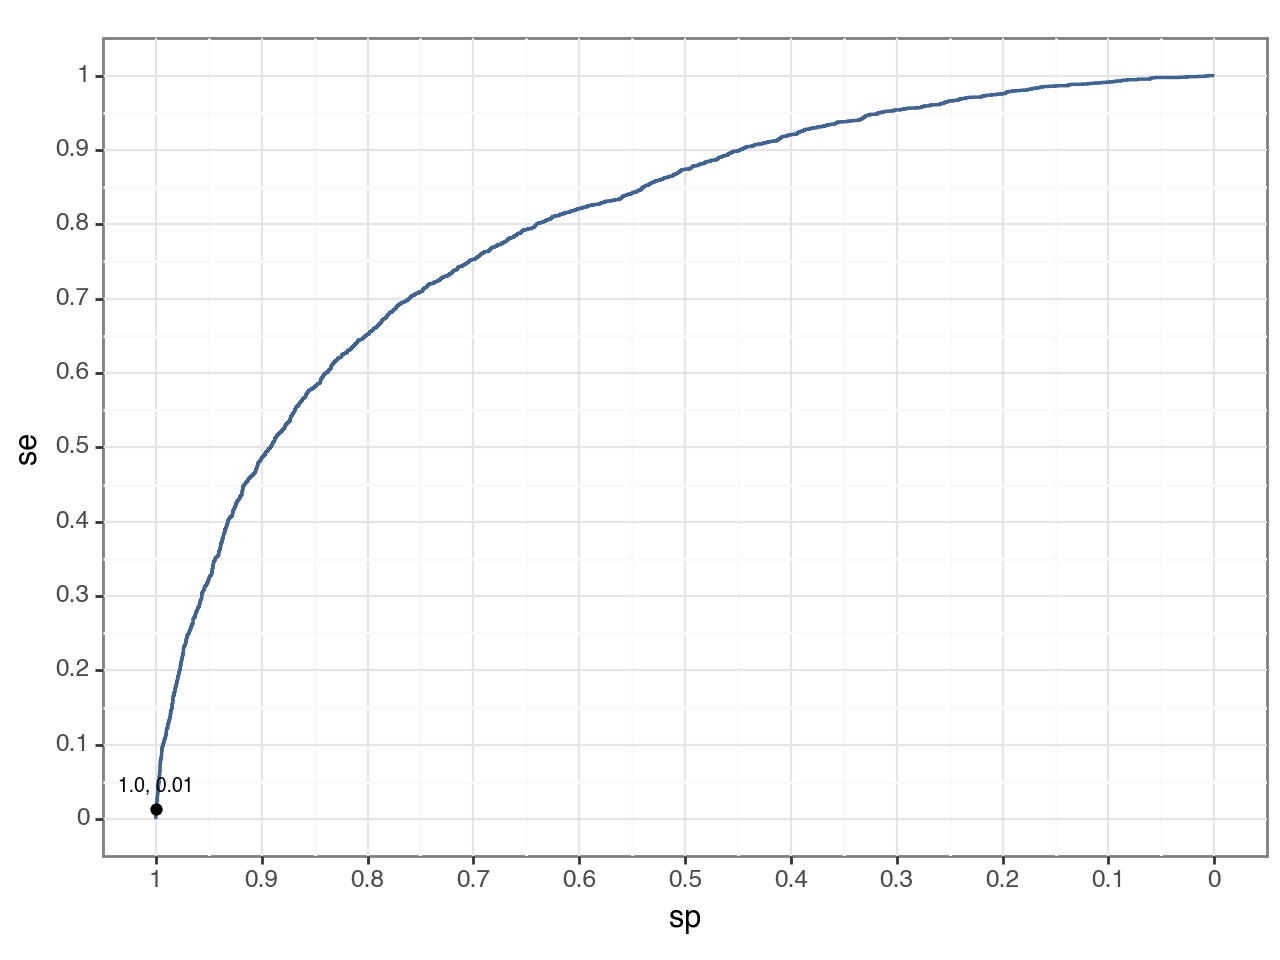

<Figure Size: (640 x 480)>

In [70]:
fig = create_roc_plot_with_optimal(fold5_all_coords['randomforestprob'], fold5_threshold['randomforestprob'])
fig.save('/Users/jacopobinati/Desktop/Prediction ML/assignment 3/visualisations/TASK1/ROC_opt.png')
fig

# TASK 2

# Categorize manufacturing and service firms

In [71]:
data['ind2'].value_counts()

ind2
56.0    8102
55.0    1752
28.0    1523
33.0    1518
26.0     828
27.0     497
29.0     206
30.0     121
Name: count, dtype: int64

In [72]:
# Create a dummy variable for manufacturing sector
manufacturing_list = [27, 29, 28, 26, 30]
data['manufacturing_dummy'] = data['ind2'].isin(manufacturing_list).astype(int)

There are a lot more service firms than manufacturing ones:

In [73]:
data['manufacturing_dummy'].value_counts()

manufacturing_dummy
0    11372
1     3175
Name: count, dtype: int64

In [74]:
# Create a dataframe for the manufacturing sector
data_manu = data[data['manufacturing_dummy'] == 1]

# Create a dataframe for the service sector
data_serv = data[data['manufacturing_dummy'] == 0]

There are around 8% of manufacturing firms that grow fast.

In [75]:
data_manu['fast_growth'].value_counts()

fast_growth
False    2221
True      954
Name: count, dtype: int64

Around 11% of service firms have fast growth rate.

In [76]:
data_serv['fast_growth'].value_counts()

fast_growth
False    7959
True     3413
Name: count, dtype: int64

## Manufacturing

In [77]:
# Define rfvars for RF
rfvars_manu  = pd.concat([data_manu[["profit_loss_year_pl", "profit_loss_year2_pl"] + rawvars + hr + qualityvars], firm], axis=1)

In [78]:
y_manu = data_manu['fast_growth']

In [79]:
indices = np.arange(len(data_manu))
index_train, index_holdout= train_test_split(
    indices, train_size=0.8, random_state=42)

In [80]:
y_train_manu = y_manu.iloc[index_train]
y_holdout_manu = y_manu.iloc[index_holdout]

In [81]:
rfvars_train_manu = rfvars_manu.iloc[index_train]
rfvars_holdout_manu = rfvars_manu.iloc[index_holdout]

In [82]:
prob_forest_manu = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid_manu = GridSearchCV(prob_forest_manu, grid, cv=k, refit='accuracy',
                                scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], n_jobs=-1)

In [83]:
prob_forest_fit_manu = prob_forest_grid_manu.fit(rfvars_train_manu, y_train_manu)

In [84]:
#create CV summary table
cv_accuracy_manu = np.zeros([6])
for i in range(5):
    cv_accuracy_manu = cv_accuracy_manu + prob_forest_fit_manu.cv_results_['split' + str(i) + '_test_accuracy']
cv_accuracy_manu = cv_accuracy_manu/5

cv_auc_manu = np.zeros([6])
for i in range(5):
    cv_auc_manu = cv_auc_manu + prob_forest_fit_manu.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc_manu = cv_auc_manu/5

cv_rmse_manu = np.zeros([6])
for i in range(5):
    cv_rmse_manu = cv_rmse_manu +np.sqrt(-1*(prob_forest_fit_manu.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse_manu = cv_rmse_manu/5

prob_forest_cv_results_manu = pd.DataFrame({
    'max_features': prob_forest_fit_manu.cv_results_['param_max_features'],
    'min_samples_split': prob_forest_fit_manu.cv_results_['param_min_samples_split'],
    'cv_accuracy_manu': cv_accuracy_manu,
    'cv_auc_manu': cv_auc_manu,
    'cv_rmse_manu': cv_rmse_manu
})

In [85]:
prob_forest_cv_results_manu

,max_features,min_samples_split,cv_accuracy_manu,cv_auc_manu,cv_rmse_manu
0,5,11,0.744882,0.688824,0.427100
1,5,16,0.747244,0.689055,0.427115
2,6,11,0.746063,0.688556,0.427056
3,6,16,0.745276,0.687965,0.427080
4,7,11,0.748819,0.687563,0.427127
5,7,16,0.744488,0.687844,0.427219


In [86]:
#obtain optimal parameter values
best_mtry_manu = prob_forest_fit_manu.best_params_['max_features']
best_min_node_size_manu = prob_forest_fit_manu.best_params_['min_samples_split']
prob_forest_fit_manu.best_params_

{'criterion': 'gini', 'max_features': 7, 'min_samples_split': 11}

In [87]:
# Get average (ie over the folds) RMSE and AUC ------------------------------------
prob_forest_best_results_manu = prob_forest_cv_results_manu[(prob_forest_cv_results_manu.max_features == best_mtry_manu) & 
                      (prob_forest_cv_results_manu.min_samples_split == best_min_node_size_manu)]
prob_forest_best_results_index_manu = prob_forest_best_results_manu.index.values[0]

CV_RMSE_manu = {}
CV_AUC_manu = {}

CV_RMSE_manu['randomforestprob'] = prob_forest_best_results_manu.cv_rmse_manu.values[0]
CV_AUC_manu['randomforestprob'] = prob_forest_best_results_manu.cv_auc_manu.values[0]

In [88]:
# Get fold level RMSE and AUC ------------------------------------

CV_RMSE_folds_rf_p = list()
for i in range(5):
    rmse = np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()[prob_forest_best_results_index]
    CV_RMSE_folds_rf_p.append(rmse)
CV_RMSE_folds['randomforestprob'] = CV_RMSE_folds_rf_p

CV_AUC_folds_rf_p = list()
for i in range(5):
    rmse = prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc'][prob_forest_best_results_index]
    CV_AUC_folds_rf_p.append(rmse)
CV_AUC_folds['randomforestprob'] = CV_AUC_folds_rf_p

In [89]:
# Loss function
# relative cost of of a false positive classification (as compared with a false negative classification)
FP_manu = 2
FN_manu = 1
cost_manu = FN_manu/FP_manu
# the prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))
prevalence_manu = y_train_manu.sum()/len(y_train_manu)

In [90]:
# Now use loss function and search for best thresholds and expected loss over folds -----
best_thresholds_manu = list()
expected_loss_manu = list()

fold = 0
for train_index, test_index in k.split(rfvars_train_manu):
    X_fold_manu = rfvars_train_manu.iloc[test_index,:]
    y_fold_manu = y_train_manu.iloc[test_index]
    
    X_fold_train_manu = rfvars_train_manu.iloc[train_index,:]
    y_fold_train_manu = y_train_manu.iloc[train_index]
    
    prob_forest_best_manu = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True,
                    criterion = 'gini', max_features = best_mtry_manu, min_samples_split = best_min_node_size_manu)
    prob_forest_best_fold_manu = prob_forest_best_manu.fit(X_fold_train_manu, y_fold_train_manu)
    pred_fold_manu = prob_forest_best_fold_manu.predict_proba(X_fold_manu)[:,1]

    false_pos_rate_manu, true_pos_rate_manu, threshold_manu = roc_curve(y_fold_manu, pred_fold_manu)
    best_threshold_manu = sorted(list(zip(np.abs(true_pos_rate_manu + (1 - prevalence_manu)/(cost_manu * prevalence_manu)*(1-false_pos_rate_manu)),\
                                       threshold_manu)), key=lambda x: x[0], reverse=True)[0][1]
    if best_threshold_manu > 1:
        best_threshold_manu = 1
    best_thresholds_manu.append(best_threshold_manu)
    threshold_prediction_manu = np.where(pred_fold_manu < best_threshold_manu, 0, 1)
    tn_manu, fp_manu, fn_manu, tp_manu = confusion_matrix(y_fold_manu, threshold_prediction_manu, labels=[0,1]).ravel()
    curr_exp_loss_manu = (fp_manu*FP_manu + fn_manu*FN_manu)/len(y_fold_manu)
    expected_loss_manu.append(curr_exp_loss_manu)
    
fold5_threshold_rf_manu = best_threshold_manu
fold5_expected_loss_rf_manu = curr_exp_loss_manu

all_coords_rf_manu = pd.DataFrame({
    'false_pos': false_pos_rate_manu*sum(y_fold_manu == 0),
    'true_pos': true_pos_rate_manu*sum(y_fold_manu == 1),
    'false_neg': sum(y_fold_manu == 1) - true_pos_rate_manu*sum(y_fold_manu == 1),
    'true_neg': sum(y_fold_manu == 0) - false_pos_rate_manu*sum(y_fold_manu == 0),
    'pos': sum(y_fold_manu == 1),
    'neg': sum(y_fold_manu == 0),
    'n': len(y_fold_manu),
    'thresholds': threshold_manu
})

In [91]:
expected_loss_cv_manu = {}
expected_loss_cv_manu['randomforestprob'] = np.mean(expected_loss_manu)

best_thresholds_cv_manu = {}
best_thresholds_cv_manu['randomforestprob'] = np.mean(best_thresholds_manu)


In [92]:
rf_summary_manu = pd.DataFrame(
    {'CV RMSE': [round(CV_RMSE_manu['randomforestprob'], 3)],
     'CV AUC': [round(CV_AUC_manu['randomforestprob'], 3)],
     'Avg of optimal thresholds': [round(best_thresholds_cv_manu['randomforestprob'], 3)],
     'Threshold for Fold5': [round(best_threshold_manu, 3)],
     'Avg expected loss': [round(expected_loss_cv_manu['randomforestprob'], 3)],
     'Expected loss for Fold5': [round(curr_exp_loss_manu, 3)]})

rf_summary_manu

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.427,0.688,0.622,0.629,0.26,0.281


RMSE, AUC, and expected loss of the RF model applied on the holdout data of manufacturing firms

In [93]:
# Take model to holdout and estimate RMSE, AUC and expected loss ------------------------------------

prob_forest_fit_best_manu = prob_forest_fit_manu.best_estimator_
rf_predicted_probabilities_holdout_manu = prob_forest_fit_best_manu.predict_proba(rfvars_holdout_manu)[:,1]
rmse_rf_manu = np.sqrt(mean_squared_error(y_holdout_manu, rf_predicted_probabilities_holdout_manu))
auc_rf_manu = roc_auc_score(y_holdout_manu, rf_predicted_probabilities_holdout_manu)
holdout_treshold_manu = np.where(rf_predicted_probabilities_holdout_manu < best_thresholds_cv_manu['randomforestprob'], 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout_manu, holdout_treshold_manu, labels=[0,1]).ravel()
expected_loss_holdout_manu = (fp*FP_manu + fn*FN_manu)/len(y_holdout_manu)

rf_holdout_results_manu = pd.DataFrame(
    {'RMSE': [round(rmse_rf_manu, 3)],
     'AUC': [round(auc_rf_manu, 3)],
     'Expected loss': [round(expected_loss_holdout_manu, 3)]})

rf_holdout_results_manu

,RMSE,AUC,Expected loss
0,0.441,0.677,0.306


In [94]:
# Confusion table

cm_object_manu = confusion_matrix(y_holdout_manu, holdout_treshold_manu, labels=[0,1])
cm_manu = pd.DataFrame(cm_object_manu, 
    index=['Actual slow growth', 'Actual fast growth'], 
    columns=['Predicted slow growth', 'Predicted fast growth'])
cm_manu

cm_percentage_manu = cm_manu / cm_manu.values.sum() * 100
cm_percentage_rounded_manu = cm_percentage_manu.round(1)
cm_percentage_rounded_manu


,Predicted slow growth,Predicted fast growth
Actual slow growth,66.3,1.4
Actual fast growth,27.7,4.6


Loss plot for the RF model applied for manufacturing firms in Fold 5 

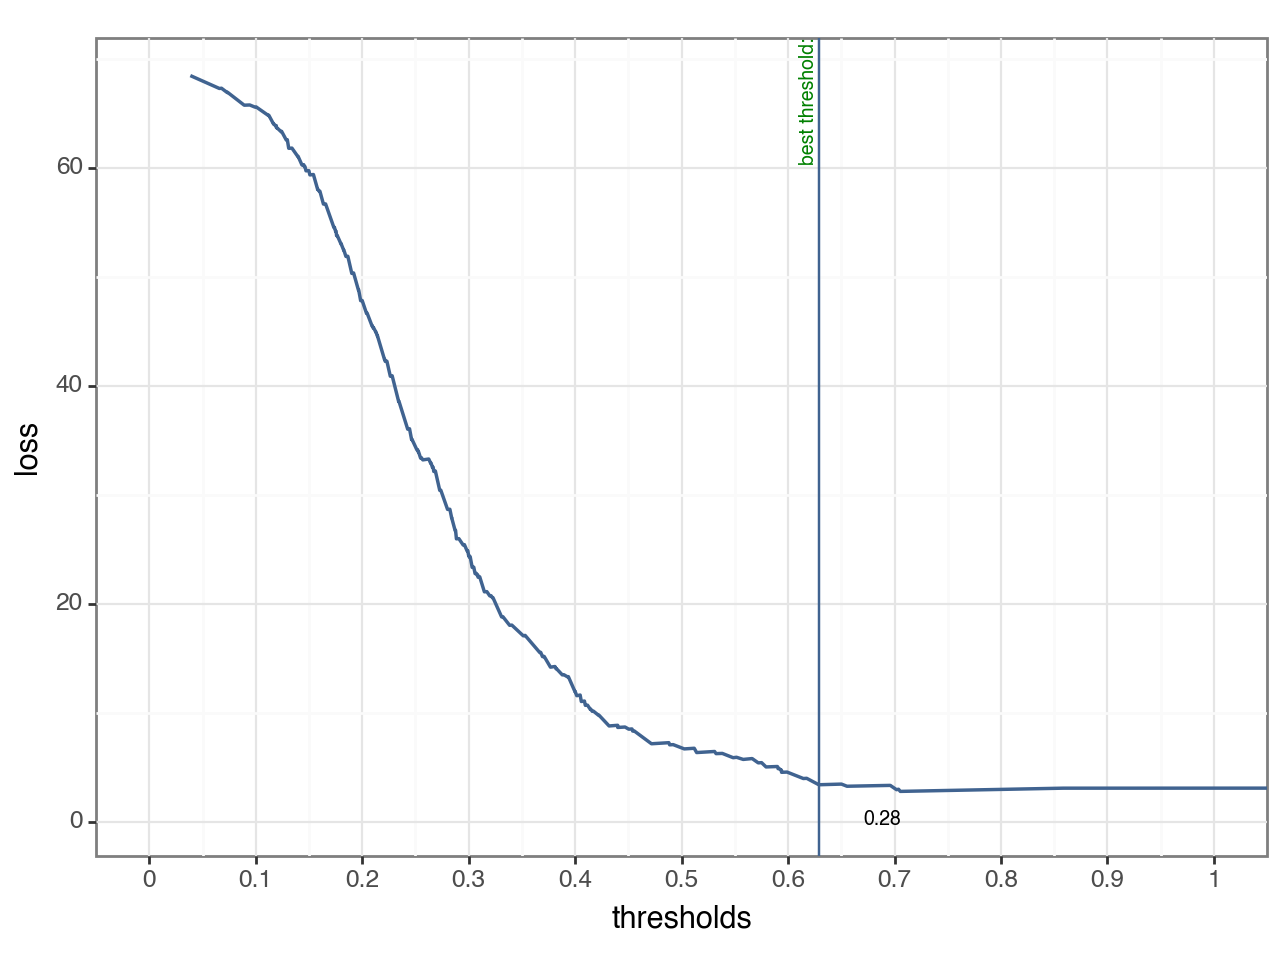

<Figure Size: (640 x 480)>

In [95]:
fig = create_loss_plot(all_coords_rf_manu, fold5_threshold_rf_manu, fold5_expected_loss_rf_manu)
fig.save('/Users/jacopobinati/Desktop/Prediction ML/assignment 3/visualisations/TASK2/loss_MANUFACTURING.png')
fig

ROC plot for the RF model applied for manufacturing firms in Fold 5 

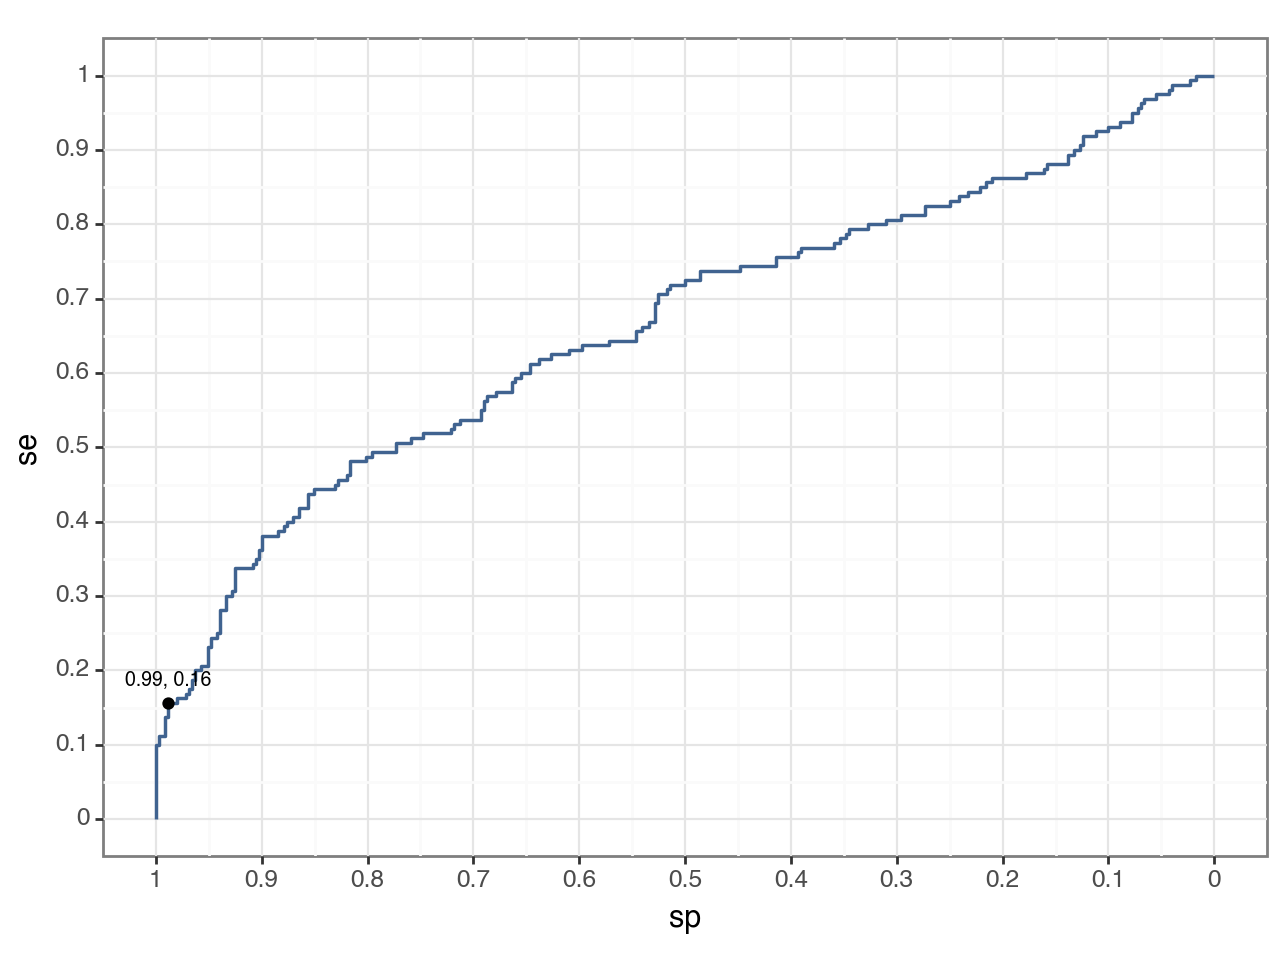

<Figure Size: (640 x 480)>

In [96]:
fig = create_roc_plot_with_optimal(all_coords_rf_manu, fold5_threshold_rf_manu)
fig.save('/Users/jacopobinati/Desktop/Prediction ML/assignment 3/visualisations/TASK2/ROC_optimal_manufacturing.png')
fig

## Service

In [97]:
# Define rfvars for RF
rfvars_serv  = pd.concat([data_serv[["profit_loss_year_pl", "profit_loss_year2_pl"] + rawvars + hr + qualityvars], firm], axis=1)

In [98]:
y_serv = data_serv['fast_growth']

In [99]:
indices = np.arange(len(data_serv))
index_train, index_holdout= train_test_split(
    indices, train_size=0.8, random_state=42)

In [100]:
y_train_serv = y_serv.iloc[index_train]
y_holdout_serv = y_serv.iloc[index_holdout]

In [101]:
rfvars_train_serv = rfvars_serv.iloc[index_train]
rfvars_holdout_serv = rfvars_serv.iloc[index_holdout]

In [102]:
prob_forest_serv = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid_serv = GridSearchCV(prob_forest_serv, grid, cv=k, refit='accuracy',
                                scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], n_jobs=-1)

In [103]:
prob_forest_fit_serv = prob_forest_grid_serv.fit(rfvars_train_serv, y_train_serv)

In [104]:
#create CV summary table
cv_accuracy_serv = np.zeros([6])
for i in range(5):
    cv_accuracy_serv = cv_accuracy_serv + prob_forest_fit_serv.cv_results_['split' + str(i) + '_test_accuracy']
cv_accuracy_serv = cv_accuracy_serv/5

cv_auc_serv = np.zeros([6])
for i in range(5):
    cv_auc_serv = cv_auc_serv + prob_forest_fit_serv.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc_serv = cv_auc_serv/5

cv_rmse_serv = np.zeros([6])
for i in range(5):
    cv_rmse_serv = cv_rmse_serv +np.sqrt(-1*(prob_forest_fit_serv.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse_serv = cv_rmse_serv/5

prob_forest_cv_results_serv = pd.DataFrame({
    'max_features': prob_forest_fit_serv.cv_results_['param_max_features'],
    'min_samples_split': prob_forest_fit_serv.cv_results_['param_min_samples_split'],
    'cv_accuracy_serv': cv_accuracy_serv,
    'cv_auc_serv': cv_auc_serv,
    'cv_rmse_serv': cv_rmse_serv
})

In [105]:
prob_forest_cv_results_serv

,max_features,min_samples_split,cv_accuracy_serv,cv_auc_serv,cv_rmse_serv
0,5,11,0.772343,0.785870,0.402440
1,5,16,0.772013,0.785842,0.402456
2,6,11,0.771683,0.787074,0.401996
3,6,16,0.772013,0.787424,0.401815
4,7,11,0.772673,0.788114,0.401288
5,7,16,0.773442,0.786350,0.401854


In [106]:
#obtain optimal parameter values
best_mtry_serv = prob_forest_fit_serv.best_params_['max_features']
best_min_node_size_serv = prob_forest_fit_serv.best_params_['min_samples_split']
prob_forest_fit_serv.best_params_

{'criterion': 'gini', 'max_features': 7, 'min_samples_split': 16}

In [107]:
# Get average (ie over the folds) RMSE and AUC ------------------------------------
prob_forest_best_results_serv = prob_forest_cv_results_serv[(prob_forest_cv_results_serv.max_features == best_mtry_serv) & 
                      (prob_forest_cv_results_serv.min_samples_split == best_min_node_size_serv)]
prob_forest_best_results_index_serv = prob_forest_best_results_serv.index.values[0]

CV_RMSE_serv = {}
CV_AUC_serv = {}

CV_RMSE_serv['randomforestprob'] = prob_forest_best_results_serv.cv_rmse_serv.values[0]
CV_AUC_serv['randomforestprob'] = prob_forest_best_results_serv.cv_auc_serv.values[0]

In [108]:
# Get fold level RMSE and AUC ------------------------------------

CV_RMSE_folds_rf_p_serv = list()
for i in range(5):
    rmse = np.sqrt(-1*(prob_forest_fit_serv.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()[prob_forest_best_results_index_serv]
    CV_RMSE_folds_rf_p_serv.append(rmse)
CV_RMSE_folds['rf_p_serv'] = CV_RMSE_folds_rf_p_serv

CV_AUC_folds_rf_p_serv = list()
for i in range(5):
    rmse = prob_forest_fit_serv.cv_results_['split' + str(i) + '_test_roc_auc'][prob_forest_best_results_index_serv]
    CV_AUC_folds_rf_p_serv.append(rmse)
CV_AUC_folds['rf_p_serv'] = CV_AUC_folds_rf_p_serv

In [109]:
# Loss function
# relative cost of of a false positive classification (as compared with a false negative classification)
FP_serv = 2
FN_serv = 1
cost_serv = FN_serv/FP_serv
# the prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))
prevalence_serv = y_train_serv.sum()/len(y_train_serv)

In [110]:
# Now use loss function and search for best thresholds and expected loss over folds -----
best_thresholds_serv = list()
expected_loss_serv = list()

fold = 0
for train_index, test_index in k.split(rfvars_train_serv):
    X_fold_serv = rfvars_train_serv.iloc[test_index,:]
    y_fold_serv = y_train_serv.iloc[test_index]
    
    X_fold_train_serv = rfvars_train_serv.iloc[train_index,:]
    y_fold_train_serv = y_train_serv.iloc[train_index]
    
    prob_forest_best_serv = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True,
                    criterion = 'gini', max_features = best_mtry_serv, min_samples_split = best_min_node_size_serv)
    prob_forest_best_fold_serv = prob_forest_best_serv.fit(X_fold_train_serv, y_fold_train_serv)
    pred_fold_serv = prob_forest_best_fold_serv.predict_proba(X_fold_serv)[:,1]

    false_pos_rate_serv, true_pos_rate_serv, threshold_serv = roc_curve(y_fold_serv, pred_fold_serv)
    best_threshold_serv = sorted(list(zip(np.abs(true_pos_rate_serv + (1 - prevalence_serv)/(cost_serv * prevalence_serv)*(1-false_pos_rate_serv)),\
                                       threshold_serv)), key=lambda x: x[0], reverse=True)[0][1]
    if best_threshold_serv > 1:
        best_threshold_serv = 1
    best_thresholds_serv.append(best_threshold_serv)
    threshold_prediction_serv = np.where(pred_fold_serv < best_threshold_serv, 0, 1)
    tn_serv, fp_serv, fn_serv, tp_serv = confusion_matrix(y_fold_serv, threshold_prediction_serv, labels=[0,1]).ravel()
    curr_exp_loss_serv = (fp_serv*FP_serv + fn_serv*FN_serv)/len(y_fold_serv)
    expected_loss_serv.append(curr_exp_loss_serv)
    
fold5_threshold_rf_serv = best_threshold_serv
fold5_expected_loss_rf_serv = curr_exp_loss_serv

all_coords_rf_serv = pd.DataFrame({
    'false_pos': false_pos_rate_serv*sum(y_fold_serv == 0),
    'true_pos': true_pos_rate_serv*sum(y_fold_serv == 1),
    'false_neg': sum(y_fold_serv == 1) - true_pos_rate_serv*sum(y_fold_serv == 1),
    'true_neg': sum(y_fold_serv == 0) - false_pos_rate_serv*sum(y_fold_serv == 0),
    'pos': sum(y_fold_serv == 1),
    'neg': sum(y_fold_serv == 0),
    'n': len(y_fold_serv),
    'thresholds': threshold_serv
})

In [113]:
expected_loss_cv_serv = {}
expected_loss_cv_serv['randomforestprob'] = np.mean(expected_loss_serv)

best_thresholds_cv_serv = {}
best_thresholds_cv_serv['randomforestprob'] = np.mean(best_thresholds_serv)

In [114]:
rf_summary_serv = pd.DataFrame(
    {'CV RMSE': [round(CV_RMSE_serv['randomforestprob'], 3)],
     'CV AUC': [round(CV_AUC_serv['randomforestprob'], 3)],
     'Avg of optimal thresholds': [round(best_thresholds_cv_serv['randomforestprob'], 3)],
     'Threshold for Fold5': [round(fold5_threshold_rf_serv, 3)],
     'Avg expected loss': [round(expected_loss_cv_serv['randomforestprob'], 3)],
     'Expected loss for Fold5': [round(fold5_expected_loss_rf_serv, 3)]})

rf_summary_serv

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.402,0.786,0.591,0.579,0.266,0.283


RMSE, AUC, and expected loss of the RF model applied on the holdout data of service firms

In [116]:
# Take model to holdout and estimate RMSE, AUC and expected loss ------------------------------------

prob_forest_fit_best_serv = prob_forest_fit_serv.best_estimator_
rf_predicted_probabilities_holdout_serv = prob_forest_fit_best_serv.predict_proba(rfvars_holdout_serv)[:,1]
rmse_rf_serv = np.sqrt(mean_squared_error(y_holdout_serv, rf_predicted_probabilities_holdout_serv))
auc_rf_serv = roc_auc_score(y_holdout_serv, rf_predicted_probabilities_holdout_serv)
holdout_treshold_serv = np.where(rf_predicted_probabilities_holdout_serv < best_thresholds_cv_serv['randomforestprob'], 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout_serv, holdout_treshold_serv, labels=[0,1]).ravel()
expected_loss_holdout_serv = (fp*FP_serv + fn*FN_serv)/len(y_holdout_serv)

rf_holdout_results_serv = pd.DataFrame(
    {'RMSE': [round(rmse_rf_serv, 3)],
     'AUC': [round(auc_rf_serv, 3)],
     'Expected loss': [round(expected_loss_holdout_serv, 3)]})

rf_holdout_results_serv

,RMSE,AUC,Expected loss
0,0.401,0.796,0.291


In [117]:
# Confusion table

cm_object_serv = confusion_matrix(y_holdout_serv, holdout_treshold_serv, labels=[0,1])
cm_serv = pd.DataFrame(cm_object_serv, 
    index=['Actual slow growth', 'Actual fast growth'], 
    columns=['Predicted slow growth', 'Predicted fast growth'])
cm_serv

cm_percentage_serv = cm_serv / cm_serv.values.sum() * 100
cm_percentage_rounded_serv = cm_percentage_serv.round(1)
cm_percentage_rounded_serv.T

,Actual slow growth,Actual fast growth
Predicted slow growth,66.1,20.8
Predicted fast growth,4.2,8.9


In [118]:
cm_percentage_rounded_serv.T

,Actual slow growth,Actual fast growth
Predicted slow growth,66.1,20.8
Predicted fast growth,4.2,8.9


Loss plot for the RF model applied for service firms in Fold 5 

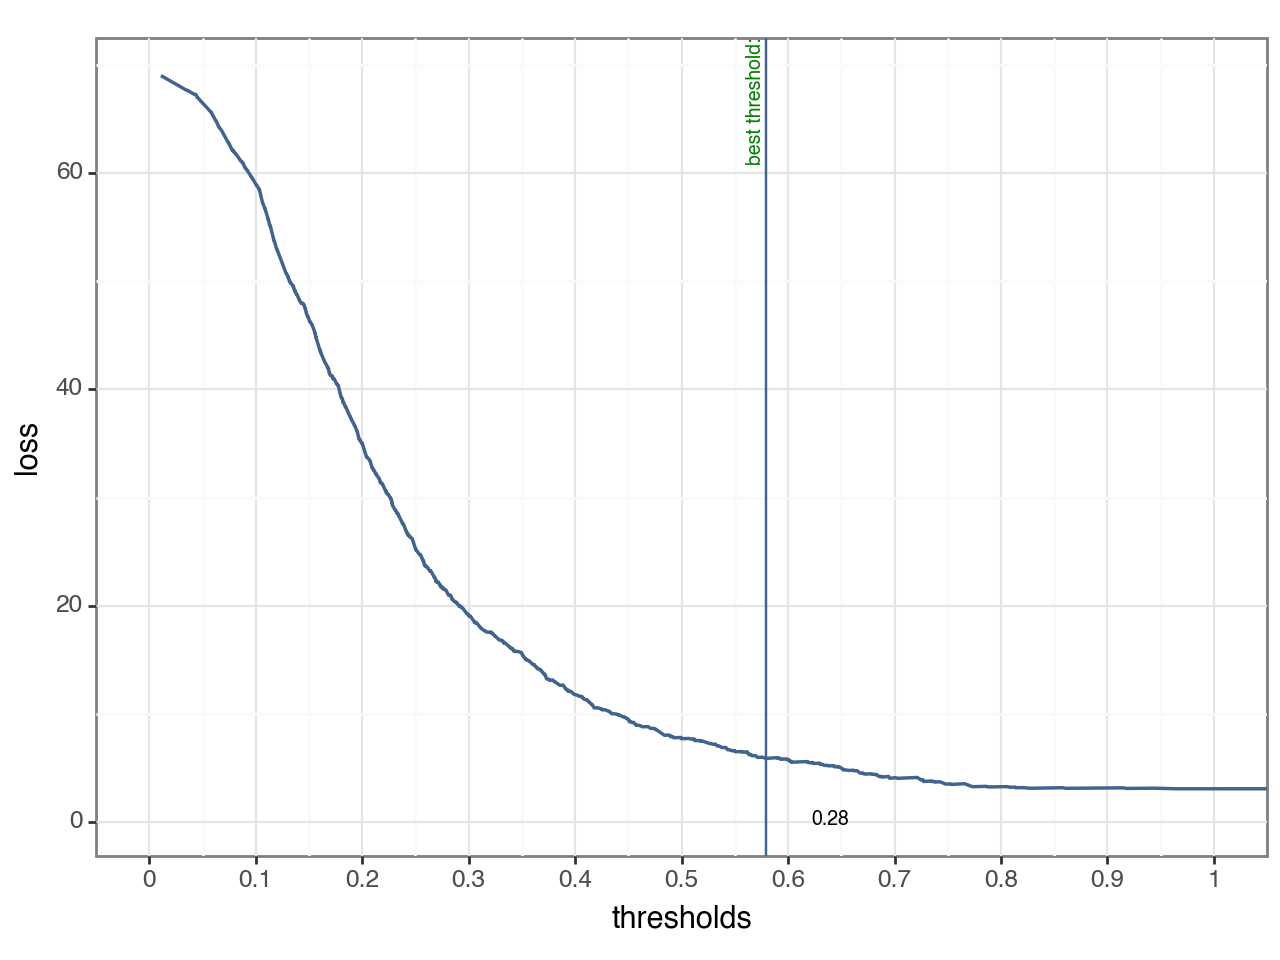

<Figure Size: (640 x 480)>

In [119]:
fig = create_loss_plot(all_coords_rf_serv, fold5_threshold_rf_serv, fold5_expected_loss_rf_serv)
fig.save('/Users/jacopobinati/Desktop/Prediction ML/assignment 3/visualisations/TASK2/loss_services.png')
fig

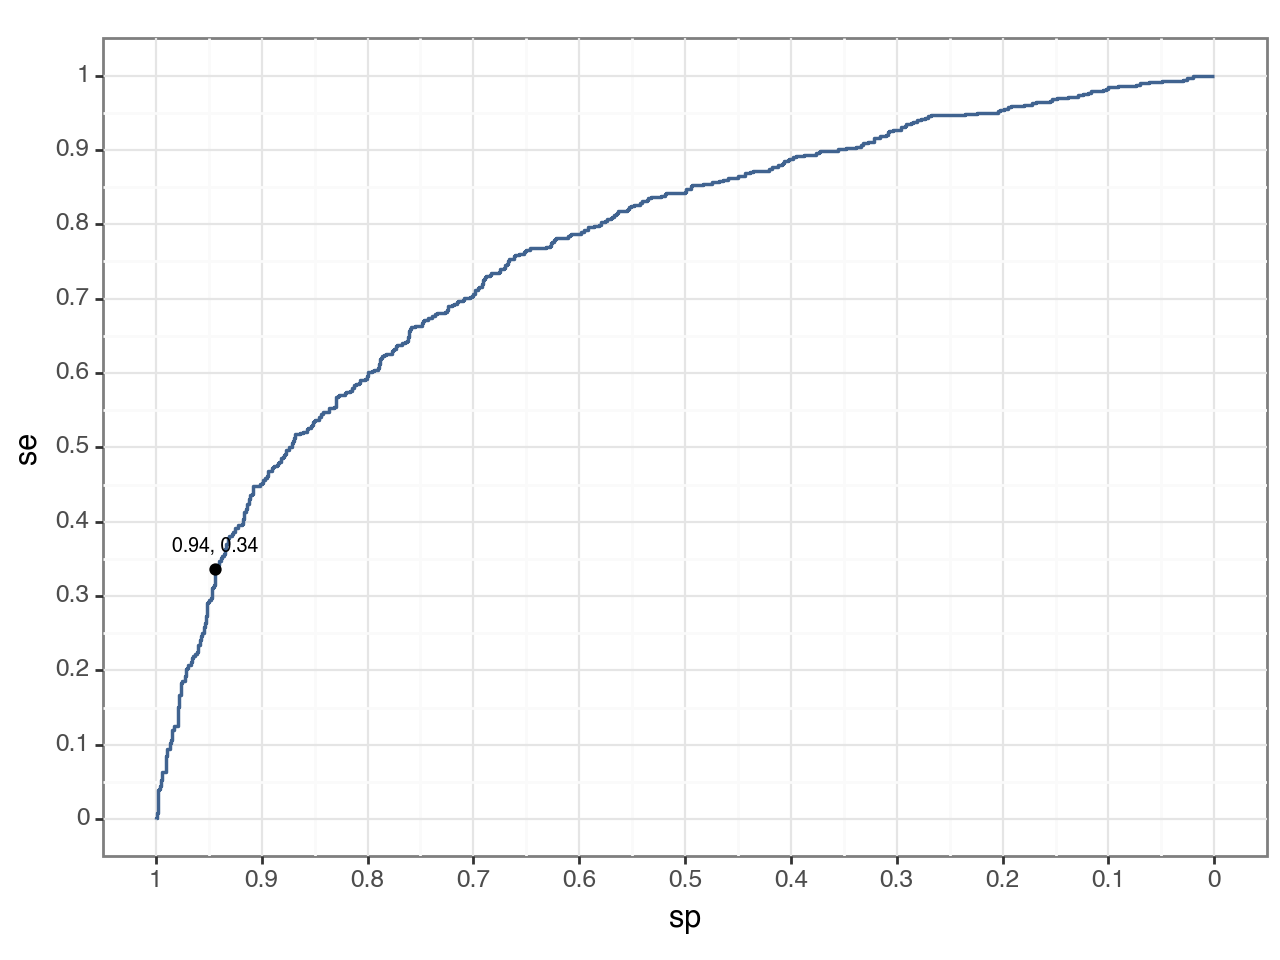

<Figure Size: (640 x 480)>

In [120]:
fig = create_roc_plot_with_optimal(all_coords_rf_serv, fold5_threshold_rf_serv)
fig.save('/Users/jacopobinati/Desktop/Prediction ML/assignment 3/visualisations/TASK2/ROC_optimal_services.png')
fig